## 1-1 Simulate a function

Requirements: 

* function need to be single-input, single-output
* function need to be non-linear

* train at least two different DNN models with the same amount of parameters until convergence
* compare the training process of models by showing the loss in each epoch in a chart
* visualize the ground-truth and predictions by models in a graph

Tips: 
* constrain the input domain
* hyper-parameters are important (i.e. tune all models to the best)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import string
import os
import math

import torch
import torchvision # Use built-in data 
from torchvision import transforms, datasets
import torch.nn as nn # contain trainable parameters
import torch.nn.functional as F #  purely functional.
import torch.nn.init as init
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [2]:
n_epochs = 100
batch_size_train = 10
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = torch.device("cuda")

sin(5\*pi\*x)/(5\*pi\*x)

In [3]:
def math_func(x):
    y = math.sin(x*5*math.pi)/(5*math.pi*x)
    return y

In [4]:
random.seed(10)
x_raw = np.asarray([round(random.random()+0.01,2) for i in range(0,1000)])
y_raw = np.asarray([math_func(x) for x in x_raw])

In [5]:
# standardize 
x = (x_raw - x_raw.mean())/x_raw.std()

In [6]:
x = torch.tensor(x_raw, dtype=torch.float32).view(-1,1).to(device)
y = torch.tensor(y_raw,dtype=torch.float32).view(-1,1).to(device)

In [7]:
ds1 = TensorDataset(x,y)
dl1 = DataLoader(ds1, batch_size=128)

In [9]:
# https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)

In [10]:
def init_weights2(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)

In [11]:
def fit(trainset, model, loss, optim, epoch, train_epoch_losses):
    running_loss = 0
    #correct = 0
    #total = 0
    #targets = []
    #predictions = []
    for batch_idx, (data, target) in enumerate(trainset):
        # clear the gradients
        optim.zero_grad()
        
        # forward pass
        output = model(data) #The outputs are energies for the 10 classes.
        ls = loss(output, target)
        
        # metrics 
        running_loss += ls.item()

        #original = target
        #original = original.cpu().numpy()
        #original = original.reshape((len(original), 1))
        #predicted =  output.data.detached().cpu().numpy()
        #total += target.size(0)
        #correct += (predicted==original).sum().item()
        
        # backward pass
        ls.backward()
        optim.step()# adjust the weights for us
        

    #train_epoch_accuracy.append(correct / total) # epoch accuracy
    train_epoch_losses.append(running_loss/len(trainset)) # divide running_loss by number of batches

Model 0: 8 layers

In [12]:
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 5),
            nn.BatchNorm1d(5),
            nn.Sigmoid()
            )
        self.layer2 = nn.Sequential(nn.Linear(5, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer3 = nn.Sequential(nn.Linear(10, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer4 = nn.Sequential(nn.Linear(10, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer5 = nn.Sequential(nn.Linear(10, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer6 = nn.Sequential(nn.Linear(10, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer7 = nn.Sequential(nn.Linear(10, 5),
            nn.BatchNorm1d(5),
            nn.Sigmoid()
            )
        self.fc8 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.fc8(x)
        return x

Model 1: 5 layers

In [13]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 10),
            nn.BatchNorm1d(10),
            nn.Sigmoid()
            )
        self.layer2 = nn.Sequential(nn.Linear(10, 19),
            nn.BatchNorm1d(19),
            nn.Sigmoid()
            )
        self.layer3 = nn.Sequential(nn.Linear(19, 15),
            nn.BatchNorm1d(15),
            nn.Sigmoid()
            )
        self.layer4 = nn.Sequential(nn.Linear(15, 4),
            nn.BatchNorm1d(4),
            nn.Sigmoid()
            )
        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc5(x)
        return x

Model 2: 2 layers

In [14]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(1, 138),
            nn.BatchNorm1d(138),
            nn.Sigmoid()
            )
        self.fc2 = nn.Linear(138, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.fc2(x)
        return x

Train each model

In [18]:
model_losses = dict()

In [19]:
# Model 1 (Net0)

loss = nn.MSELoss()
model1 = Net0().to(device)
model1.apply(init_weights2)
optimizer = SGD(model1.parameters(), lr=1e-2, momentum=momentum)

train_epoch_losses = []

n_epoch = 20000
for epoch in range(1,n_epoch+1):
    fit(dl1, model1, loss, optimizer, epoch, train_epoch_losses)
    if epoch % 100 ==0:
        print('Epoch:{} Loss: {}'.format(epoch,train_epoch_losses[-1]))

model_losses[1] = train_epoch_losses

Epoch:100 Loss: 0.005600028183835093
Epoch:200 Loss: 0.004384816205856623
Epoch:300 Loss: 0.003634822896856349
Epoch:400 Loss: 0.0031842605239944533
Epoch:500 Loss: 0.002900594594393624
Epoch:600 Loss: 0.0026703494950197637
Epoch:700 Loss: 0.0024724981558392756
Epoch:800 Loss: 0.002300814143382013
Epoch:900 Loss: 0.002172927459469065
Epoch:1000 Loss: 0.0020531125483103096
Epoch:1100 Loss: 0.0019052940187975764
Epoch:1200 Loss: 0.0018637574030435644
Epoch:1300 Loss: 0.0017225588162546046
Epoch:1400 Loss: 0.001630062353797257
Epoch:1500 Loss: 0.0015980157841113396
Epoch:1600 Loss: 0.0016423451961600222
Epoch:1700 Loss: 0.0015749649501231033
Epoch:1800 Loss: 0.0015291459239961114
Epoch:1900 Loss: 0.0015139334755076561
Epoch:2000 Loss: 0.001517513628641609
Epoch:2100 Loss: 0.0015153842905419879
Epoch:2200 Loss: 0.0014949074102332816
Epoch:2300 Loss: 0.0014695130485051777
Epoch:2400 Loss: 0.0014460876227531116
Epoch:2500 Loss: 0.0014256581634981558
Epoch:2600 Loss: 0.001408052492479328
Epoc

In [20]:
# Model 2 (Net1)

loss = nn.MSELoss()
model2 = Net1().to(device)
model2.apply(init_weights2)
optimizer = SGD(model2.parameters(), lr=1e-2, momentum=momentum)

train_epoch_losses = []

n_epoch = 20000
for epoch in range(1,n_epoch+1):
    fit(dl1, model2, loss, optimizer, epoch, train_epoch_losses)
    if epoch % 100 ==0:
        print('Epoch:{} Loss: {}'.format(epoch,train_epoch_losses[-1]))

model_losses[2] = train_epoch_losses

Epoch:100 Loss: 0.01019141887081787
Epoch:200 Loss: 0.004309586744057015
Epoch:300 Loss: 0.0038495127228088677
Epoch:400 Loss: 0.003478136961348355
Epoch:500 Loss: 0.003296890230558347
Epoch:600 Loss: 0.003188106999004958
Epoch:700 Loss: 0.0031130016832321417
Epoch:800 Loss: 0.003034343615581747
Epoch:900 Loss: 0.0029518722512875684
Epoch:1000 Loss: 0.002869157902750885
Epoch:1100 Loss: 0.002782208197459113
Epoch:1200 Loss: 0.0026899314689217135
Epoch:1300 Loss: 0.002582660992629826
Epoch:1400 Loss: 0.002554702172346879
Epoch:1500 Loss: 0.0025523687145323493
Epoch:1600 Loss: 0.002556481329520466
Epoch:1700 Loss: 0.0025555336324032396
Epoch:1800 Loss: 0.0025482878045295365
Epoch:1900 Loss: 0.0025362722371937707
Epoch:2000 Loss: 0.002521369227906689
Epoch:2100 Loss: 0.0025049262621905655
Epoch:2200 Loss: 0.0024878246913431212
Epoch:2300 Loss: 0.002470630824973341
Epoch:2400 Loss: 0.002453737623000052
Epoch:2500 Loss: 0.00243722405139124
Epoch:2600 Loss: 0.0024211344425566494
Epoch:2700 L

In [21]:
# Model 3 (Net2)

loss = nn.MSELoss()
model3 = Net2().to(device)
model3.apply(init_weights2)
optimizer = SGD(model3.parameters(), lr=1e-2, momentum=momentum)

train_epoch_losses = []

n_epoch = 20000
for epoch in range(1,n_epoch+1):
    fit(dl1, model3, loss, optimizer, epoch, train_epoch_losses)
    if epoch % 100 ==0:
        print('Epoch:{} Loss: {}'.format(epoch,train_epoch_losses[-1]))

model_losses[3] = train_epoch_losses

Epoch:100 Loss: 0.05717470683157444
Epoch:200 Loss: 0.052337867207825184
Epoch:300 Loss: 0.04754511220380664
Epoch:400 Loss: 0.042872910387814045
Epoch:500 Loss: 0.03873322322033346
Epoch:600 Loss: 0.0354106614831835
Epoch:700 Loss: 0.0329796364530921
Epoch:800 Loss: 0.031313428189605474
Epoch:900 Loss: 0.030149513389915228
Epoch:1000 Loss: 0.02940738690085709
Epoch:1100 Loss: 0.02884476468898356
Epoch:1200 Loss: 0.02843021391890943
Epoch:1300 Loss: 0.028083614073693752
Epoch:1400 Loss: 0.027816174551844597
Epoch:1500 Loss: 0.02758579235523939
Epoch:1600 Loss: 0.027406224748119712
Epoch:1700 Loss: 0.027236665366217494
Epoch:1800 Loss: 0.027124435640871525
Epoch:1900 Loss: 0.027024720329791307
Epoch:2000 Loss: 0.026938667986541986
Epoch:2100 Loss: 0.026863994542509317
Epoch:2200 Loss: 0.026796197053045034
Epoch:2300 Loss: 0.02673787623643875
Epoch:2400 Loss: 0.026694281958043575
Epoch:2500 Loss: 0.02665308746509254
Epoch:2600 Loss: 0.02661587856709957
Epoch:2700 Loss: 0.0265819078776985

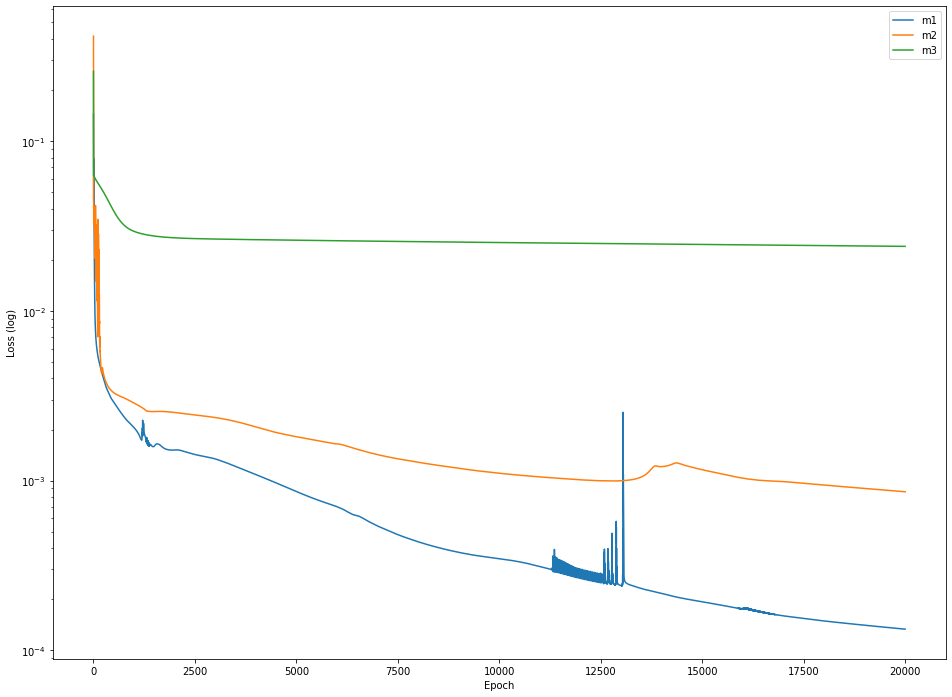

In [22]:
fig = plt.figure(figsize=(16,12))

plt.plot(model_losses[1], label = "m1")
plt.plot(model_losses[2], label = "m2")
plt.plot(model_losses[3], label = "m3")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log)")
plt.legend()

plt.savefig("./Figures/1-1 Simulation.png",transparent=False)
fig.show()

In [28]:
testx_raw = np.asarray([i/100 for i in range(1,102)])
testy_raw = np.asarray([math_func(x) for x in testx_raw])

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01])

In [32]:
testx = (testx_raw - x_raw.mean())/x_raw.std()

testx = torch.tensor(testx_raw, dtype=torch.float32).view(-1,1).to(device)
testy = torch.tensor(testy_raw,dtype=torch.float32).view(-1,1).to(device)

ds1_te = TensorDataset(testx,testy)
dl1_te = DataLoader(ds1_te, batch_size=128)

In [46]:
def test(model, testx):
    with torch.no_grad():            
        output = model(testx) #The outputs are energies for the 10 classes.
        predicted =  output.data.cpu().numpy()
        return predicted


In [47]:
pred_1 = test(model1, testx)
pred_2 = test(model2, testx)
pred_3 = test(model3, testx)

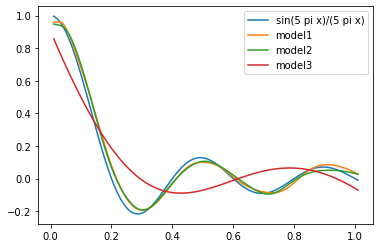

In [52]:
plt.plot(testx_raw,testy_raw, label = "sin(5 pi x)/(5 pi x)")
plt.plot(testx_raw,pred_1, label = "model1")
plt.plot(testx_raw,pred_2, label = "model2")
plt.plot(testx_raw,pred_3, label = "model3")
plt.legend()